In [1]:
import pandas as pd
df = pd.read_csv('/kaggle/input/romdatududd/Data.csv', header=0)
df

,Reviews,Sentiments
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive
...,...,...
34163,very nice bhook lagne lagi biryani ko dakh k,Positive
34164,koi bna dy.........fishh,Neutral
34165,bi kha k tu dkho bht mazy ki hoti h,Positive
34166,Try ki hai but pata nhi kiu I just don't like ...,Negative


In [2]:
df[df['Sentiments'] == 'Neative']

,Reviews,Sentiments
13277,product achi hai but wrong waist size send kar...,Neative


In [3]:
df.loc[df['Sentiments']=='Neative', 'Sentiments'] = 'Negative'

In [4]:
nan_values = df.isna().sum()

# Print the number of NaN values for each column
print("NaN values per column:")
print(nan_values)

NaN values per column:
Reviews       2
Sentiments    9
dtype: int64


In [5]:
df.dropna(subset=['Reviews', 'Sentiments'], inplace=True)

In [6]:
nan_values = df.isna().sum()

# Print the number of NaN values for each column
print("NaN values per column:")
print(nan_values)

NaN values per column:
Reviews       0
Sentiments    0
dtype: int64


In [8]:
# Mapping labels to integers
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['Sentiments'] = df['Sentiments'].map(label_mapping)
df

,Reviews,Sentiments
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,2.0
1,sahi bt h,2.0
2,"Kya bt hai,",2.0
3,Wah je wah,2.0
4,Are wha kaya bat hai,2.0
...,...,...
34163,very nice bhook lagne lagi biryani ko dakh k,2.0
34164,koi bna dy.........fishh,1.0
34165,bi kha k tu dkho bht mazy ki hoti h,2.0
34166,Try ki hai but pata nhi kiu I just don't like ...,0.0


In [9]:
nan_values = df.isna().sum()

# Print the number of NaN values for each column
print("NaN values per column:")
print(nan_values)

NaN values per column:
Reviews        0
Sentiments    13
dtype: int64


In [10]:
df.dropna(subset=['Reviews', 'Sentiments'], inplace=True)

In [11]:
nan_values = df.isna().sum()

# Print the number of NaN values for each column
print("NaN values per column:")
print(nan_values)

NaN values per column:
Reviews       0
Sentiments    0
dtype: int64


In [12]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv1D, Bidirectional, GRU, Dense, Embedding, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight







/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
# Tokenization using DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Convert the text column to a list of strings
text_list = df['Reviews'].astype(str).tolist()

# Tokenize the text
encoded_texts = tokenizer(text_list, padding=True, truncation=True, return_tensors='tf')


# Convert the 'input_ids' tensor to a NumPy array
X = encoded_texts['input_ids'].numpy()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Sentiments'], test_size=0.2, random_state=42)




In [15]:
# Define the neural network model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.get_vocab()), output_dim=32, input_length=X.shape[1]))
model.add(Conv1D(128, 5, activation='relu'))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Dense(3, activation='softmax'))  # Assuming 3 classes (Negative, Neutral, Positive)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 32)           976704    
                                                                 
 conv1d (Conv1D)             (None, 508, 128)          20608     
                                                                 
 spatial_dropout1d (Spatial  (None, 508, 128)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 508, 128)          74496     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                        

214/214 [==============================] - 5s 23ms/step


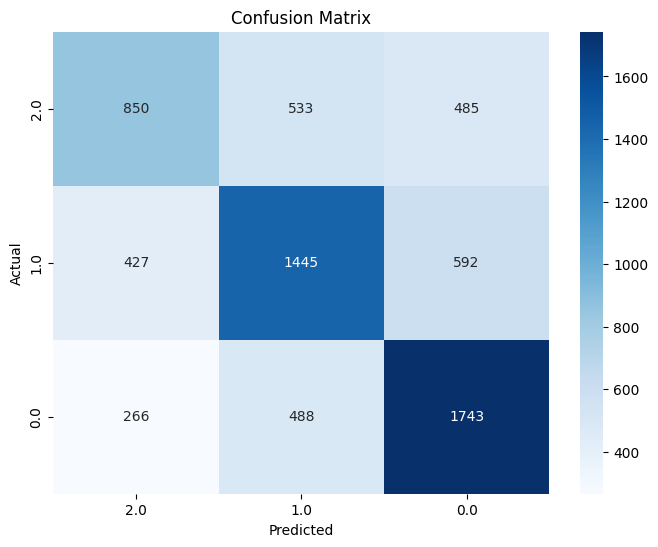

Classification Report:
              precision    recall  f1-score   support

         2.0       0.55      0.46      0.50      1868
         1.0       0.59      0.59      0.59      2464
         0.0       0.62      0.70      0.66      2497

    accuracy                           0.59      6829
   macro avg       0.58      0.58      0.58      6829
weighted avg       0.59      0.59      0.59      6829



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred_probs = model.predict(X_test)
y_pred_classes = y_pred_probs.argmax(axis=-1)

# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)
class_names = df['Sentiments'].unique()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_namess = [str(label) for label in class_names]

#
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_namess))